In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# pip install xarray-spatial

In [ ]:
# import geopandas as gpd
# gpd.read_file("https://dea-public-data.s3-ap-southeast-2.amazonaws.com/derivative/ga_s2ls_intertidal_cyear_3/ga_summary_grid_c3_32km_coastal.geojson")

## Cost distance

In [3]:
import numpy as np
import xarray as xr
from skimage import graph

import datacube
import odc.geo.xr
from odc.geo.geobox import GeoBox
from odc.geo.gridspec import GridSpec
from odc.geo.types import xy_
from odc.algo import mask_cleanup

dc = datacube.Datacube()


def _cost_distance(
    cost_surface, start_array, sampling=None, geometric=True, **mcp_kwargs
):
    """
    Calculate accumulated least-cost distance through a cost surface
    array from a set of starting cells to every other cell in an array,
    using methods from `skimage.graph.MCP` or `skimage.graph.MCP_Geometric`.

    Parameters
    ----------
    cost_surface : ndarray
        A 2D array representing the cost surface.
    start_array : ndarray
        A 2D array with the same shape as `cost_surface` where non-zero
        values indicate start points.
    sampling : tuple, optional
        For each dimension, specifies the distance between two cells.
        If not given or None, unit distance is assumed.
    geometric : bool, optional
        If True, `skimage.graph.MCP_Geometric` will be used to calculate
        costs, accounting for the fact that diagonal vs. axial moves
        are of different lengths and weighting path costs accordingly.
        If False, costs will be calculated simply as the sum of the
        values of the costs array along the minimum cost path.
    **mcp_kwargs :
        Any additiona keyword arguments to pass to `skimage.graph.MCP`
        or `skimage.graph.MCP_Geometric`.

    Returns
    -------
    lcd : ndarray
        A 2D array of the least-cost distances from the start cell to all other cells.
    """

    # Initialise relevant least cost graph
    if geometric:
        lc_graph = graph.MCP_Geometric(
            costs=cost_surface,
            sampling=sampling,
            **mcp_kwargs,
        )
    else:
        lc_graph = graph.MCP(
            costs=cost_surface,
            sampling=sampling,
            **mcp_kwargs,
        )

    # Extract starting points from the array (pixels with non-zero values)
    starts = list(zip(*np.nonzero(start_array)))

    # Calculate the least-cost distance from the start cell to all other cells
    lcd = lc_graph.find_costs(starts=starts)[0]

    return lcd


def xr_cost_distance(cost_da, starts_da, use_cellsize=False, geometric=True):
    """
    Calculate accumulated least-cost distance through a cost surface
    array from a set of starting cells to every other cell in an
    xarray.DataArray, returning results as an xarray.DataArray.

    Parameters
    ----------
    cost_da : xarray.DataArray
        An xarray.DataArray representing the cost surface, where pixel
        values represent the cost of moving through each pixel.
    starts_da : xarray.DataArray
        An xarray.DataArray with the same shape as `cost_da` where non-
        zero values indicate start points for the distance calculation.
    use_cellsize : bool, optional
        Whether to incorporate cell size when calculating the distance
        between two cells, based on the spatial resolution of the array.
        Default is False, which will assume distances between cells will
        be based on cost values only.
    geometric : bool, optional
        If True, `skimage.graph.MCP_Geometric` will be used to calculate
        costs, accounting for the fact that diagonal vs. axial moves
        are of different lengths and weighting path costs accordingly.
        If False, costs will be calculated simply as the sum of the
        values of the costs array along the minimum cost path.

    Returns
    -------
    costdist_da : xarray.DataArray
        An xarray.DataArray providing least-cost distances between every
        cell and the nearest start cell.
    """

    # Use resolution from input arrays if requested
    if use_cellsize:
        x, y = cost_da.odc.geobox.resolution.xy
        cellsize = (abs(y), abs(x))
    else:
        cellsize = None

    # Compute least cost array
    costdist_array = _cost_distance(
        cost_da, starts_da.values, sampling=cellsize, geometric=geometric
    )

    # Wrap as xarray
    costdist_da = xr.DataArray(costdist_array, coords=cost_da.coords)

    return costdist_da


def load_connectivity_mask(
    dc,
    geobox,
    product="ga_srtm_dem1sv1_0",
    elevation_band="dem_h",
    resampling="bilinear",
    buffer=20000,
    max_threshold=100,
    mask_filters=[("dilation", 3)],
    **cost_distance_kwargs,
):
    """
    Generates a mask based on connectivity to ocean pixels, using least-
    cost distance weighted by elevation. By incorporating elevation,
    this mask will extend inland further in areas of low lying elevation
    and less far inland in areas of steep terrain.

    Parameters
    ----------
    dc : Datacube
        A Datacube instance for loading data.
    geobox : ndarray
        The GeoBox defining the pixel grid to load data into (e.g.
        resolution, extents, CRS).
    product : str, optional
        The name of the DEM product to load from the datacube.
        Defaults to "ga_srtm_dem1sv1_0".
    elevation_band : str, optional
        The name of the band containing elevation data. Defaults to
        "height_depth".
    resampling : str, optional
        The resampling method to use, by default "bilinear".
    buffer : int, optional
        The distance by which to buffer the input GeoBox to reduce edge
        effects. This buffer will eventually be removed and clipped back
        to the original GeoBox extent. Defaults to 20,000 metres.
    max_threshold: int, optional
        Value used to threshold the resulting cost distance to produce
        a mask.
    mask_filters : list of tuples, optional
        An optional list of morphological processing steps to pass to
        the `mask_cleanup` function. The default is `[("dilation", 3)]`,
        which will dilate True pixels by a radius of 3 pixels.
    **cost_distance_kwargs :
        Optional keyword arguments to pass to the ``xr_cost_distance``
        cost-distance function.

    Returns
    -------
    costdist_mask : xarray.DataArray
        An output boolean mask, where True represent pixels located in
        close cost-distance proximity to the ocean.
    costdist_da : xarray.DataArray
        The output cost-distance array, reflecting distance from the
        ocean weighted by elevation.
    """

    # Buffer input geobox and reduce resolution to ensure that the
    # connectivity analysis is less affected by edge effects
    geobox_buffered = GeoBox.from_bbox(
        geobox.buffered(xbuff=buffer, ybuff=buffer).boundingbox,
        resolution=30,
        tight=True,
    )

    # Load DEM data
    dem_da = dc.load(
        product="ga_srtm_dem1sv1_0",
        measurements=[elevation_band],
        resampling="bilinear",
        like=geobox_buffered,
    ).squeeze()[elevation_band]

    # Identify starting points (ocean nodata points)
    starts_da = dem_da == dem_da.nodata

    # Calculate cost surface (negative values are not allowed, so
    # negative nodata values are resolved by clipping values to between
    # 0 and infinity)
    costs_da = dem_da.clip(0, np.inf)

    # Run cost distance surface
    costdist_da = xr_cost_distance(
        cost_da=costs_da,
        starts_da=starts_da,
        **cost_distance_kwargs,
    )

    # Reproject back to original geobox extents and resolution
    costdist_da = costdist_da.odc.reproject(how=geobox)

    # Apply threshold
    costdist_mask = costdist_da < max_threshold

    # If requested, apply cleanup
    if mask_filters is not None:
        costdist_mask = mask_cleanup(costdist_mask, mask_filters=mask_filters)

    return costdist_mask, costdist_da

## Extents experiments

In [96]:
import odc.geo.xr
from odc.geo.xr import xr_zeros
import datacube

from intertidal.io import load_ocean_mask, load_aclum_mask, load_topobathy_mask, extract_geobox
from intertidal.elevation import ocean_connection

dc = datacube.Datacube()

# # Port Headland
# t, l = -20.290330, 118.539614
# b, r = -20.361810, 118.649425

# # Brisbane
# t, l = -27.327456, 153.048808
# b, r = -27.498525, 153.223553

# # Darwin
# t, l = -12.319448, 130.788848
# b, r = -12.570606, 131.040905

# # Sandbanks
# t, l = -12.420474, 130.257363
# b, r = -12.727552, 130.552566

# # Roebuck
# t, l = -17.903231, 122.128631
# b, r = -18.269155, 122.442974

# Mangroves
t, l = -14.789750913940455, 128.28100450913448
b, r = -15.117758745491248, 128.62668326122676

# # Mangroves QLD
# t, l = -19.758851667078883, 147.65388229853954
# b, r = -19.88273733756646, 147.85964346049923

# # NSW
# t, l = -37.229126, 149.917234
# b, r = -37.304341, 150.063105

# # Bucaneer
# t, l = -14.88435, 125.20966
# b, r = -14.96435, 125.29966

# # Groote
# t, l = -13.8905,136.3212
# b, r = -14.0905,136.5296

# # NSW
# t, l = -29.33876, 153.10319
# b, r = -29.52876, 153.39319

# # Vic
# t, l = -38.300407, 142.267423
# b, r = -38.377945, 142.488557


# study_area = "x153y095"  # Victorian lake misclassification
study_area = "x186y148"  # Townsville (mangroves)
study_area = "x125y166"  # mangroves nt
study_area = "x105y154"  # roebuck
study_area = "x177y081"  # corner inlet
study_area = "x153y096"  # sa lakes
study_area = "x156y097"  # sa adelaide
study_area = "x202y117"  # brisbane
study_area = "x153y163"  # gulf carpentaria

geobox = extract_geobox(study_area=study_area)


query_params = dict(
    # x=(l, r),
    # y=(t, b),
    like=geobox,
    time=("2018", "2018"),
)

load_params = dict(
    # measurements=["elevation",],
    # dask_chunks={},
)

ds = dc.load(
    product="ga_s2ls_intertidal_cyear_3",
    **query_params,
    **load_params,
).squeeze()


In [97]:
# Load other inputs
ocean_mask = load_ocean_mask(dc, ds.odc.geobox.compat)
urban_mask = load_aclum_mask(dc, ds.odc.geobox.compat)
bathy_mask = load_topobathy_mask(dc, ds.odc.geobox.compat)
costdist_mask, _ = load_connectivity_mask(dc, ds.odc.geobox, buffer=0)

# Extract classes
is_nan = (ds.qa_ndwi_freq == ds.qa_ndwi_freq.nodata) & bathy_mask
mostly_dry = (ds.qa_ndwi_freq < 50) & ~is_nan
mostly_wet = (ds.qa_ndwi_freq >= 50) & ~is_nan
intertidal_lc = (ds.qa_ndwi_corr >= 0.15) & costdist_mask
intertidal_hc = ds.elevation.notnull()

# Create ocean connected mask
mostly_wet_inland = mostly_wet & ~costdist_mask

# Inland urban misclassifications
urban_misclass = mostly_wet_inland & urban_mask


In [99]:
# Combine all classifications
extents = xr_zeros(geobox=ds.odc.geobox, dtype="int16")
extents.values[mostly_wet] = 1
extents.values[mostly_wet_inland] = 4
extents.values[urban_misclass] = 5
extents.values[mostly_dry] = 5
extents.values[intertidal_lc] = 2

# Sieve small classes
from rasterio.features import sieve
extents.values[:] = sieve(extents.values, size=5)

# Add high confidence intertidal on top
extents.values[intertidal_hc] = 3

# Export to file
extents.attrs["nodata"] = 0
extents.odc.write_cog(f"/gdata1/projects/coastal/intertidal/experimental_extents/experimental_extents_{study_area}.tif", overwrite=True)


PosixPath('/gdata1/projects/coastal/intertidal/experimental_extents/experimental_extents_x153y163.tif')

### Classes

0. Nodata
1. Ocean and coastal waters
2. Intertidal (low confidence)
3. Intertidal (high confidence)
4. Inland waters
5. Land

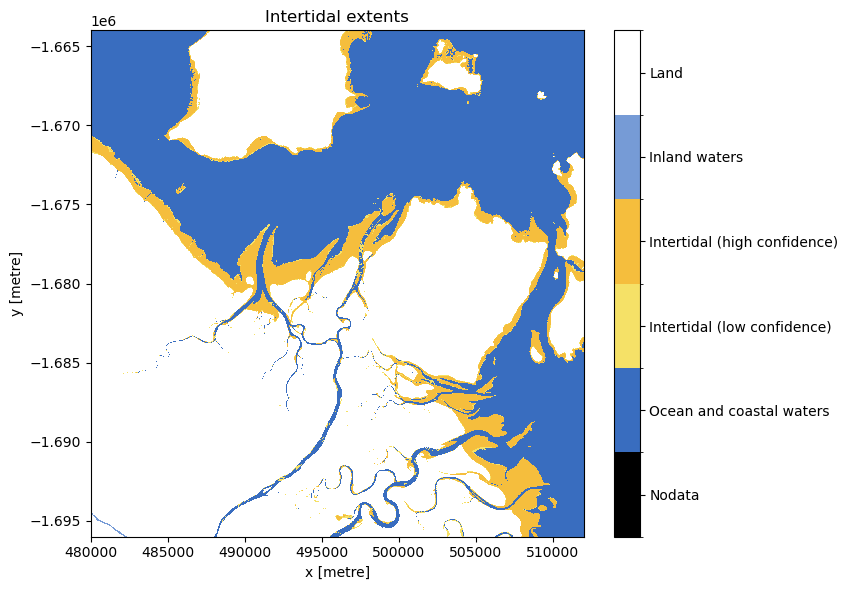

In [100]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define colors and labels
colors = ['#000000', '#396dbf', '#f5e167', '#f5be3d', '#769bd6', '#FFFFFF']
labels = ["Nodata", "Ocean and coastal waters", "Intertidal (low confidence)", "Intertidal (high confidence)", "Inland waters", "Land"]

# Create a custom colormap and normalize
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=range(7), ncolors=6)

# Plot
fig, ax = plt.subplots(figsize=(8.5, 6))
im = extents.plot.imshow(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=range(6))
cbar.set_ticks([i + 0.5 for i in range(6)])
cbar.set_ticklabels(labels)

plt.title('Intertidal extents')
plt.tight_layout()
plt.show()
plt.figure

fig.savefig(f"/gdata1/projects/coastal/intertidal/experimental_extents/experimental_extents_{study_area}.png", bbox_inches="tight", dpi=200)

## Cost distance experiments

In [ ]:
study_areas = [
    # "x079y130", 'x080y127', 'x081y136', 'x084y139', 'x088y143',
    # 'x090y101', 'x096y094', 'x109y157', 'x110y158', 'x112y160',
    # 'x113y160', 'x114y164', 
    
    'x082y125', 'x090y104', 'x092y144', 'x094y145', 'x105y154',
    'x107y159', 'x107y174', 'x109y099', 'x110y160', 'x111y162',
    'x120y105', 'x125y166', 'x134y175', 'x134y178', 'x137y175',
    'x140y177', 'x144y104', 'x149y167', 'x153y095', 'x153y163',
    'x154y169', 'x154y178', 'x155y102', 'x156y096', 'x164y084',
    'x166y083', 'x167y156', 'x171y173', 'x173y084', 'x173y179',
    'x174y066', 'x174y082', 'x177y081', 'x178y066', 'x179y166',
    'x182y164', 'x186y148', 'x187y085', 'x189y090', 'x191y094',
    'x191y145', 'x193y096', 'x193y139', 'x194y136', 'x196y100',
    'x198y131', 'x201y110', 'x202y117', 'x202y124',    
    
    'x116y169', 'x118y169', 'x120y169',
    'x128y166', 'x129y166', 'x129y167', 'x130y166', 'x130y167',
    'x132y174', 'x147y098', 'x157y093', 'x159y092', 'x160y087',
    'x160y090', 'x161y086', 'x170y082', 'x172y075', 'x173y069',
    'x173y074', 'x176y073', 'x176y173', 'x180y082', 'x181y083',
    'x184y152', 'x188y147', 'x189y146', 'x190y092', 'x194y098',
    'x198y103', 'x199y130'
]

for study_area in study_areas:

    print(f"Processing {study_area}")
    geobox = extract_geobox(study_area=study_area)
    costdist_mask = load_connectivity_mask(dc, geobox)
    costdist_mask.astype("int16").odc.write_cog(
        f"data/connectivity_mask/connectivity_mask_{study_area}.tif", overwrite=True
    )

In [ ]:
input_path = "data/connectivity_mask/*.tif"
output_path = "connectivity_mask.tif" 

!gdalwarp $input_path $output_path -b 1 -overwrite -multi -wm 80% -co NUM_THREADS=ALL_CPUS -of COG -co COMPRESS=DEFLATE -co PREDICTOR=YES

In [ ]:
costdist_mask.astype("int16").plot.imshow()

In [ ]:
# study_areas = [
#                'x082y125', 'x090y104', 'x092y144', 'x094y145', 'x105y154',
#                'x107y159', 'x107y174', 'x109y099', 'x110y160', 'x111y162',
#                'x120y105', 'x125y166', 'x134y175', 'x134y178', 'x137y175',
#                'x140y177', 'x144y104', 'x149y167', 'x153y095', 'x153y163',
#                'x154y169', 'x154y178', 'x155y102', 'x156y096', 'x164y084',
#                'x166y083', 'x167y156', 'x171y173', 'x173y084', 'x173y179',
#                'x174y066', 'x174y082', 'x177y081', 'x178y066', 'x179y166',
#                'x182y164', 'x186y148', 'x187y085', 'x189y090', 'x191y094',
#                'x191y145', 'x193y096', 'x193y139', 'x194y136', 'x196y100',
#                'x198y131', 'x201y110', 'x202y117', 'x202y124',
# ]

study_areas = [
    "x079y130", 'x080y127', 'x081y136', 'x084y139', 'x088y143',
    'x090y101', 'x096y094', 'x109y157', 'x110y158', 'x112y160',
    'x113y160', 'x114y164', 'x116y169', 'x118y169', 'x120y169',
    'x128y166', 'x129y166', 'x129y167', 'x130y166', 'x130y167',
    'x132y174', 'x147y098', 'x157y093', 'x159y092', 'x160y087',
    'x160y090', 'x161y086', 'x170y082', 'x172y075', 'x173y069',
    'x173y074', 'x176y073', 'x176y173', 'x180y082', 'x181y083',
    'x184y152', 'x188y147', 'x189y146', 'x190y092', 'x194y098',
    'x198y103', 'x199y130'
]

for study_area in study_areas:

    try:
        print(f"Processing {study_area}")
        gbox = extract_geobox(study_area=study_area)
        gbox_buffered = gbox.buffered(xbuff=20000, ybuff=20000).zoom_out(3)

        # Load SRTM
        srtm_ds = dc.load(
            product="ga_srtm_dem1sv1_0",
            measurements=["dem_h"],
            resampling="bilinear",
            like=gbox_buffered,
        ).squeeze()
        dem_da = srtm_ds.dem_h

        # Identify ocean-connected starting points for distance calculation
        # ocean_da = load_ocean_mask(dc, geobox=gbox_buffered)
        # water_pixels = dem_da <= 0
        # starts = ocean_connection(water_pixels, ocean_da).odc.assign_crs(crs=srtm_ds.odc.crs)

        # Identify starting points (ocean nodata points), and cost
        # surface (negative nodata points clipped to a minimum of 0)
        starts = dem_da == dem_da.nodata
        cost_surface = dem_da.clip(0, np.inf)

        # Generate least cost distance array
        cost_distance_da = xr.apply_ufunc(
            cost_distance,
            cost_surface,
            starts,
        ).odc.assign_crs(crs=srtm_ds.odc.crs)

        # Export to file
        cost_distance_da.attrs["nodata"] = np.nan
        cost_distance_da.odc.write_cog(
            f"data/least_cost_distance/cost_distance_{study_area}.tif",
            overwrite=True,
        )
    except:
        print(f"{study_area} failed")

In [ ]:
input_path = "data/least_cost_distance_unit/cost_distance_*.tif"
output_path = "least_cost_distance_unit.tif" 

!gdalwarp $input_path $output_path -b 1 -overwrite -multi -wm 80% -co NUM_THREADS=ALL_CPUS -of COG -co COMPRESS=DEFLATE -co PREDICTOR=YES

In [ ]:
# intertidal_ds = dc.load(
#     product="ga_s2ls_intertidal_cyear_3",
#     time="2018",
#     measurements="qa_ndwi_freq",
#     like=gbox,
# ).squeeze()


In [ ]:
srtm_ds = dc.load(
    product="ga_srtm_dem1sv1_0",
    measurements=["dem_s"],
    resampling="bilinear",
    like=gbox_buffered,
).squeeze()

dem_da = srtm_ds.dem_s

In [ ]:
# Identify ocean-connected starting points for distance calculation
ocean_da = load_ocean_mask(dc, geobox=gbox_buffered)
water_pixels = dem_da <= 0
starts = ocean_connection(water_pixels, ocean_da).odc.assign_crs(crs=srtm_ds.odc.crs)
starts.astype("float32").odc.explore()

# Test
# freq_reprojected = intertidal_ds.qa_ndwi_freq.astype("float32").odc.reproject(
#     how=gbox_buffered, dst_nodata=np.nan
# )
# water_pixels = xr.where(freq_reprojected > 10, True, dem_da <= 0)

In [ ]:


# cost_surface = dem_da.clip(5, 5000) / 5
cost_surface = dem_da.clip(0, np.inf)
# cost_surface = dem_da.clip(5, np.inf) - 5
# cost_surface = scale_values(dem_da, in_min=5, in_max=15, out_min=1, out_max=1000)
cost_distance_da = xr.apply_ufunc(
    cost_distance, cost_surface, starts, gbox_buffered.resolution.x
).odc.assign_crs(crs=srtm_ds.odc.crs)

In [ ]:
cost_distance_da.odc.write_cog("cost_distance.tif", overwrite=True)

In [ ]:
cost_surface.odc.explore(robust=True)

In [ ]:
# cost_surface.odc.write_cog("cost_surface.tif", overwrite=True)

In [ ]:
(dem_da < 5).odc.explore()

In [ ]:
dem_da.where(dem_da> 0).plot.hist(bins=100);

In [ ]:
import numpy as np
from skimage.graph import MCP, MCP_Geometric

# Define a simple 5x5 cost array
cost_array = np.array([
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]
])

# Starting point
start = (2, 0)

import matplotlib.pyplot as plt
plt.imshow(cost_array)

In [ ]:
# Initialize MCP
mcp = MCP(cost_array, sampling=(10, 10))

# Use find_costs to calculate costs
costs, traceback = mcp.find_costs([start])

# Print the results
print("MCP Costs Array:")
print(costs)
plt.imshow(costs)

In [ ]:
# Initialize MCP_Geometric
mcp_geom = MCP_Geometric(cost_array)  #, sampling=(10, 10))

# Use find_costs to calculate costs
costs_geom, traceback_geom = mcp_geom.find_costs([start])

# Print the results
print("MCP_Geometric Costs Array:")
print(costs_geom)
plt.imshow(costs_geom)

In [ ]:
scale_values(dem_da).plot.imshow()

In [ ]:
# unexplained = (extents== 0).where(~is_nan)

In [ ]:
# ds.qa_ndwi_corr.where(~is_nan).where(unexplained).max()

In [ ]:
ds.qa_ndwi_corr.odc.write_cog("experimental_extents_corr.tif")

In [ ]:
ds.qa_ndwi_freq.odc.write_cog("experimental_extents_freq.tif", overwrite=True)

In [ ]:
mostly_dry.astype('int16').odc.write_cog("experimental_extents_mostly_dry.tif", overwrite=True)

In [ ]:
mostly_wet.astype('int16').odc.write_cog("experimental_extents_mostly_wet.tif", overwrite=True)

In [ ]:
ocean_connected_mask.astype('int16').odc.write_cog("experimental_extents_ocean_connected.tif", overwrite=True)

In [ ]:
is_nan.astype('int16').odc.write_cog("experimental_extents_is_nan.tif", overwrite=True)

## Seasonal correction

In [ ]:
from intertidal.io import load_data
from dea_tools.coastal import tidal_tag
from dea_tools.dask import create_local_dask_cluster

client = create_local_dask_cluster(return_client=True)

In [ ]:
ds_ndwi = load_data(dc=dc, geom=ds.odc.geobox.extent)[0].compute()

In [ ]:
ds_ndwi = tidal_tag(ds_ndwi)

In [ ]:
ds_ndwi.isel(time=0).ndwi.plot()

In [ ]:
timestep = 191
ds_ndwi.tide_m.plot()
plt.scatter(
    x=ds_ndwi.isel(time=timestep).time.values,
    y=ds_ndwi.isel(time=timestep).tide_m.values,
    color="orange",
)

In [ ]:
ds_ndwi.isel(time=ds_ndwi.tide_m > 0.1).median(dim="time").ndwi.odc.explore()

In [ ]:
ds_ndwi.isel(time=ds_ndwi.tide_m < -0.2).median(dim="time").ndwi.odc.explore()

In [ ]:
import xarray as xr
da_corr = xr.corr(ds_ndwi.ndwi > 0, ds_ndwi.tide_m, dim="time")
da_corr.odc.assign_crs(ds_ndwi.odc.crs).odc.explore(cmap="RdBu", vmin=-0.5, vmax=0.5)

In [ ]:
import xarray as xr
# da_corr = xr.corr(ds_ndwi.ndwi > 0, ds_ndwi.tide_m, dim="time")
da_corr.odc.assign_crs(ds_ndwi.odc.crs).odc.explore(cmap="RdBu", vmin=-0.5, vmax=0.5)

In [ ]:
import xarray as xr
gb = ds_ndwi.tide_m.groupby("time.month")
tide_array = gb - gb.mean()  #.rolling(month=3, center=True, min_periods=1).mean()
da_corr = xr.corr(ds_ndwi.ndwi, tide_array, dim="time")
da_corr.odc.assign_crs(ds_ndwi.odc.crs).odc.explore(cmap="RdBu", vmin=-0.5, vmax=0.5)

In [ ]:
da_corr.odc.write_cog("test.tif", overwrite=True)

In [ ]:
gb.mean().rolling(month=3, center=True, min_periods=1).mean().plot()
gb.mean().plot()

In [ ]:
ds_ndwi.tide_m.plot()

In [ ]:
ds_ndwi.ndwi.mean(dim=["x", "y"]).plot()

In [ ]:
x, y = 915170.25, -4231317.71
plt.scatter(
    x=ds_ndwi.tide_m,
    y=ds_ndwi.ndwi.sel(x=x, y=y, method="nearest"),
    # s=(ds_ndwi.ndwi.notnull().mean(dim=["x", "y"]) + 1) ** 5,
)

In [ ]:
xr.corr

In [ ]:
x, y = 915170.25, -4231317.71

gb = ds_ndwi.tide_m.groupby("time.month")
tide_array = gb - gb.mean()


plt.scatter(
    x=tide_array,
    y=ds_ndwi.ndwi.sel(x=x, y=y, method="nearest"),
    # s=(ds_ndwi.ndwi.notnull().mean(dim=["x", "y"]) + 1) ** 5,
)

In [ ]:
ds_ndwi.tide_m.plot()
ds_ndwi.tide_m.pad(time=50, mode="constant", constant_values=1.23456789)   #.plot()


#.rolling(time=80, center=True, min_periods=1).mean().plot()

In [ ]:
# ausbathytopo_ds = dc.load(
#     product="ga_ausbathytopo250m_2023",
#     measurements=["height_depth"],
#     resampling="cubic",
#     like=ds.odc.geobox.buffered(20000, 20000),
# ).squeeze()

# dem_da = ausbathytopo_ds.height_depth

In [ ]:
srtm_ds = dc.load(
    product="ga_srtm_dem1sv1_0",
    measurements=["dem_s"],
    resampling="bilinear",
    like=ds.odc.geobox.buffered(20000, 20000),
).squeeze()

dem_da = srtm_ds.dem_s

In [ ]:
dem_da.odc.explore()

In [ ]:
from intertidal.extents import ocean_connection
from intertidal.io import load_ocean_mask
ocean_da = load_ocean_mask(dc, geobox=ds.odc.geobox.buffered(20000, 20000))
starts = ocean_connection(dem_da <= 0, ocean_da)
starts.odc.explore()

In [ ]:
# dem_da = ((srtm_ds.dem_s + ausbathytopo_ds.height_depth) / 2.0)   #.odc.write_cog("mean_dem.tif")

In [ ]:
# dem_da = np.maximum(srtm_ds.dem_s, ausbathytopo_ds.height_depth)

In [ ]:
# (ds_dem2.dem_s == 0).plot.imshow()

In [ ]:
from skimage import graph
import numpy as np
import xarray as xr


def cost_distance(cs, start_array, cellsize=10):

    # From the cost-surface create a 'landscape graph' object which can then be
    # analysed using least-cost modelling
    lg = graph.MCP_Geometric(cs, sampling=(cellsize, cellsize))
    # lg = graph.MCP(cs)

    # Set starting points
    starts = list(zip(*np.nonzero(start_array)))

    # Calculate the least-cost distance from the start cell to all other cells
    lcd = lg.find_costs(starts=starts)[0]

    return lcd

# cost_distance(cs=ds.height_depth.values, start_array=(ds.height_depth > 0).values, cellsize=10)

from xrspatial import slope
from odc.algo import mask_cleanup

# land = ds_dem.height_depth > 0
# starts = (mask_cleanup(land, [("dilation", 1)]) &  ~land)
# land = dem_da > 0
# starts = ~land

# starts = ausbathytopo_ds.height_depth < 0

# slope_da = slope(ds.height_depth)
# slope_da = np.abs(dem_da.clip(-50, 50))
# cs = slope_da.where(~slope_da.isnull(), -1)
cs = dem_da.clip(1, 5000)
test = xr.apply_ufunc(cost_distance, cs, starts, 10)

In [ ]:
# from xrspatial import allocation, proximity

# test = proximity(dem_da, target_values=[0])

In [ ]:
# test.plot.imshow()

In [ ]:
# test.plot.imshow()

In [ ]:
# ds.odc.explore()

In [ ]:
# test.odc.assign_crs(crs=ds_dem.odc.crs).odc.explore()

In [ ]:
# test.where(np.isfinite(test), 0)

test.odc.assign_crs(crs=ds_dem.odc.crs).odc.write_cog("test_distance.tif", overwrite=True)

In [ ]:
# (test < 5000).plot()  #.odc.assign_crs(crs=ds_dem.odc.crs).odc.explore()